In [1]:
import os

import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import seaborn as sns
import gpytorch
import torch

from REStats.utils import load_SCADA, filter_outliers, downsample, standardize, calc_err
from REStats.plots import save_figs, plot_wind_rose
from REStats.models import power_curve, iec_power_curve

In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

In [4]:
wt = load_SCADA(2018)
cut_in = 2.0
cut_out = 18.0
wt = wt[(wt.wind_speed >= cut_in) & (wt.wind_speed < cut_out)]

In [5]:
# 1. Filter outliers
wt_filtered = filter_outliers(wt)

# 2. Downsample to 1h
wt_input = downsample(wt_filtered)
wt_input = wt_input.dropna()

# 3. Standardize
wt_std = standardize(wt_input)

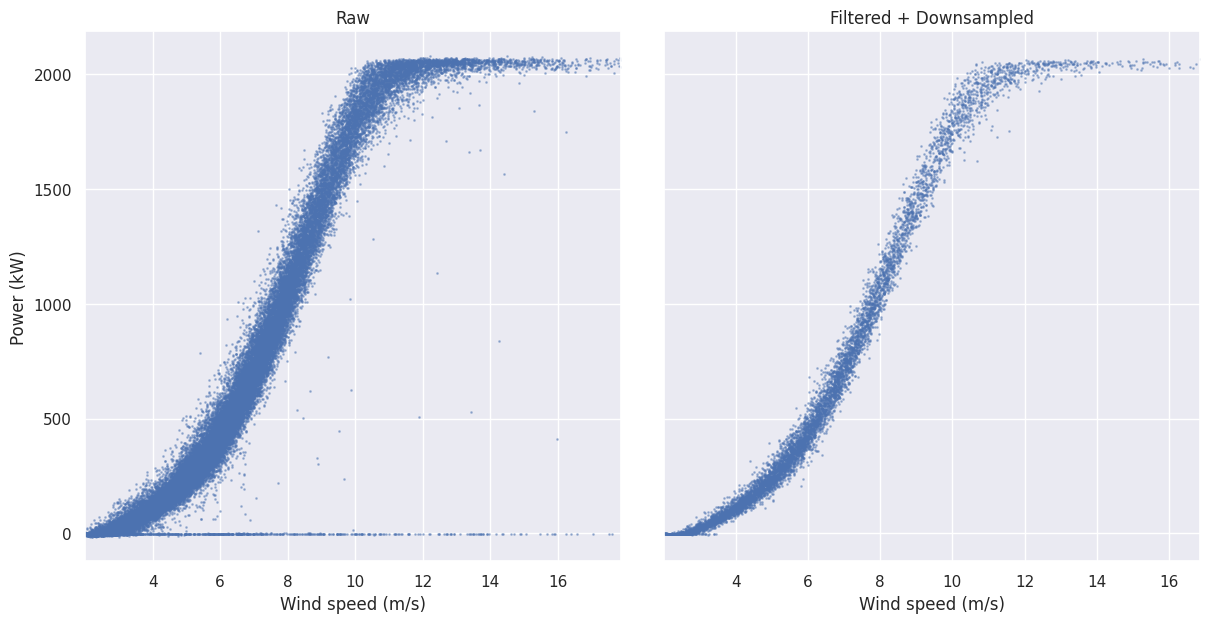

In [6]:
filtered_pc, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
filtered_pc.tight_layout()
axes[0].set_ylabel("Power (kW)")
for ax in axes:
    ax.set_xmargin(0)
    ax.set_xlabel("Wind speed (m/s)")

axes[0].set_title("Raw")
axes[1].set_title("Filtered + Downsampled")
axes[0].scatter(wt.wind_speed, wt.power, s=1, alpha=0.4)
axes[1].scatter(wt_input.wind_speed, wt_input.power, s=1, alpha=0.4)

figs["filtered_pc"] = filtered_pc

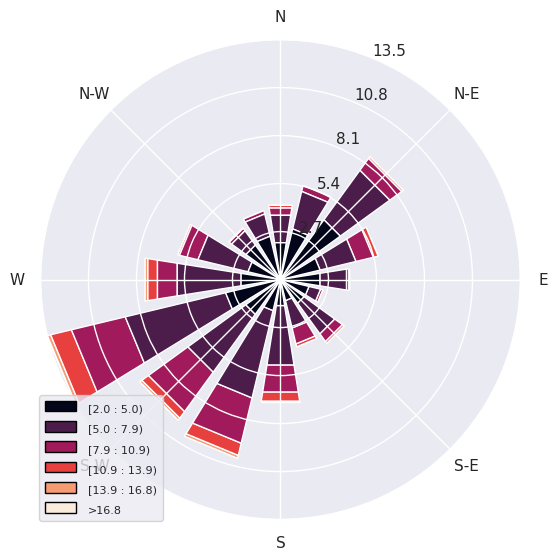

In [7]:
cmap = ListedColormap(sns.color_palette())
fig = plot_wind_rose(wt_input, figsize=(6, 6))

figs["wind_rose"] = fig

In [8]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_input.wind_speed.to_numpy()[:, None])

train, test = train_test_split(wt_input, stratify=bins, train_size=800, test_size=1000, random_state=1)

train["power_std"] = (train.power - train.power.mean())/train.power.std()

train.head()

,wind_speed,wind_dir,power,turbulence_intensity,power_std
Date,,,,,
2018-08-25 06:00:00,7.472366,274.830450,912.896545,0.020927,0.482799
2018-02-16 05:00:00,6.904288,246.455119,720.623505,0.017393,0.166322
2018-03-29 13:00:00,5.454393,130.283627,351.346336,0.024402,-0.441501
2018-12-27 20:00:00,4.374084,305.846356,128.273926,0.034731,-0.808674
2018-04-08 17:00:00,2.411751,42.334898,-0.849332,0.048532,-1.021208


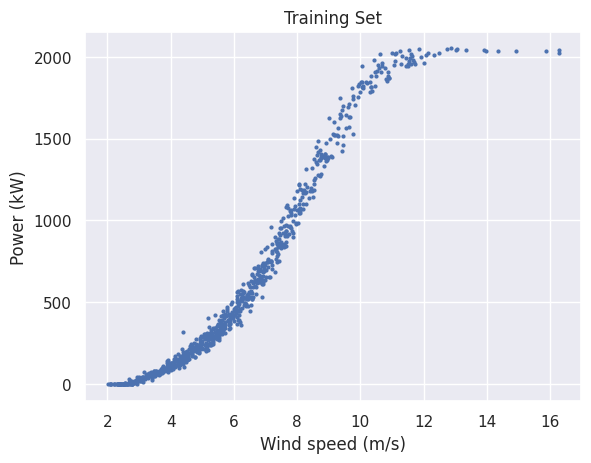

In [9]:
fig, ax = plt.subplots()
ax.set_title("Training Set")
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")

ax.scatter(train.wind_speed, train.power, s=4)

figs["pc_train_set"] = fig

## IEC Method

In [10]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_input.wind_speed.to_numpy()[:, None])

iec_train, iec_test = train_test_split(wt_input, stratify=bins, test_size=1000, random_state=1)


iec_pc = iec_power_curve.fit(iec_train)
iec_pc.head()

,wind_speed,wind_dir,power,turbulence_intensity
wind_speed,,,,
"(2.0, 2.5]",2.313517,168.552329,-0.956466,0.056111
"(2.5, 3.0]",2.764086,158.208718,9.567924,0.049474
"(3.0, 3.5]",3.260089,186.841526,44.329660,0.041950
"(3.5, 4.0]",3.740164,168.018721,88.277405,0.036665
"(4.0, 4.5]",4.249570,180.905768,140.922985,0.032747


In [11]:
iec_pred = [iec_pc.loc[ws, "power"] for ws in iec_test.wind_speed]

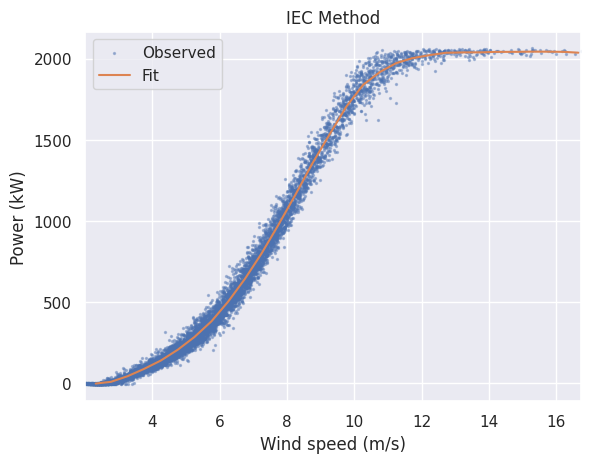

In [12]:
iec_pc_fig, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_title("IEC Method")

ax.scatter(iec_train.wind_speed, iec_train.power, s=2, alpha=.4, color="C0", label="Observed")
ax.plot(iec_pc.wind_speed, iec_pc.power, color="C1", label="Fit")

ax.legend()

figs["iec_pc"] = iec_pc_fig

In [13]:
rmse = mean_squared_error(iec_pred, iec_test.power, squared=False)
mae = mean_absolute_error(iec_pred, iec_test.power)

print(f"IEC RMSE: {rmse} kW")
print(f"IEC RMSE (%): {rmse/iec_test.power.mean()*100}")
print(f"IEC MAE: {mae} kW")

IEC RMSE: 57.36568099688427 kW
IEC RMSE (%): 9.28409784218566
IEC MAE: 39.67988090282246 kW


## Gaussian Process -> Prior predictive

In [14]:
def plot_prior_predictive_samples(model, x, n_samples=1):
    """
    Generate and plot prior predictive samples for a given GP model.

    Args:
        model (ExactGPModel): An instance of the ExactGPModel class.
        x (torch.Tensor): Input data.
        n_samples (int): Number of samples to generate.
    """
    # Generate prior predictive samples
    samples = model.prior_predictive_samples(x, n_samples=n_samples)

    # Convert x to numpy for plotting
    x_np = x.detach().numpy()

    # Plot the samples
    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(n_samples):
        ax.plot(x_np, samples[i].detach().numpy(), lw=1.5)

    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.title(f"{n_samples} Prior Predictive Samples")
    
    return fig

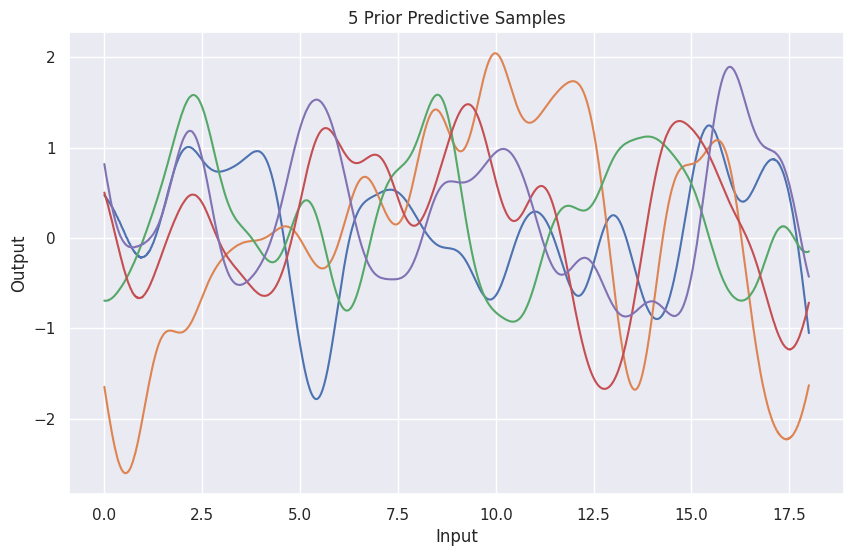

In [15]:
# Generate synthetic data
train_x = torch.tensor([])
train_y = torch.tensor([])

# Define a likelihood and a GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = power_curve.ExactGPModel(train_x, train_y, likelihood)

# Generate input data for prior predictive samples
x = torch.linspace(0, 18, 2000)

# Call the function to generate and plot prior predictive samples
fig = plot_prior_predictive_samples(model, x, n_samples=5)

figs["gp_prior"] = fig

## Wind speed only

In [16]:
train_std = standardize(train)

X_train = torch.tensor(train_std.wind_speed)
y_train = torch.tensor(train_std.power_std)

model, likelihood = power_curve.fit(X_train, y_train)

Iter 1/100 - Loss: 0.769   lengthscale: [[0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.731   lengthscale: [[0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.693   lengthscale: [[0.7979171276092529]]   noise: 0.598
Iter 4/100 - Loss: 0.654   lengthscale: [[0.8535302877426147]]   noise: 0.554
Iter 5/100 - Loss: 0.615   lengthscale: [[0.9110372066497803]]   noise: 0.513
Iter 6/100 - Loss: 0.575   lengthscale: [[0.9702078700065613]]   noise: 0.474
Iter 7/100 - Loss: 0.535   lengthscale: [[1.0307636260986328]]   noise: 0.437
Iter 8/100 - Loss: 0.494   lengthscale: [[1.0923585891723633]]   noise: 0.403
Iter 9/100 - Loss: 0.452   lengthscale: [[1.1545705795288086]]   noise: 0.370
Iter 10/100 - Loss: 0.410   lengthscale: [[1.2169030904769897]]   noise: 0.340
Iter 11/100 - Loss: 0.368   lengthscale: [[1.278794765472412]]   noise: 0.312
Iter 12/100 - Loss: 0.325   lengthscale: [[1.339623212814331]]   noise: 0.286
Iter 13/100 - Loss: 0.282   lengthscale: [[1.3987046480178833]]

In [17]:
fit_x = np.linspace(cut_in, np.ceil(train.wind_speed.max()), 200)
fit_x_std = (fit_x - train.wind_speed.mean())/train.wind_speed.std()
fit_x_std = torch.tensor(fit_x_std, dtype=torch.float32)
fit_pred = power_curve.predict(model, likelihood, fit_x_std)

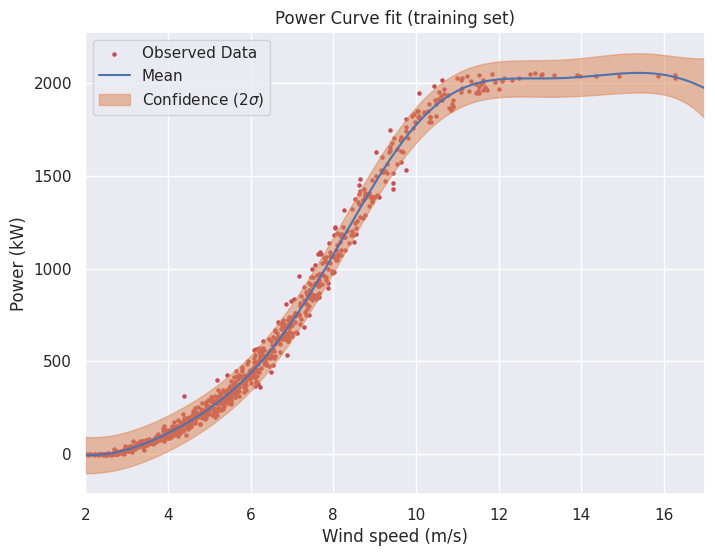

In [28]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xmargin(0)
    ax.set_title("Power Curve fit (training set)")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power (kW)")

    # Get upper and lower confidence bounds
    lower, upper = fit_pred.confidence_region()
    # Plot training data
    ax.scatter(train.wind_speed, train.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(fit_x, fit_pred.mean.numpy() * train.power.std() + train.power.mean(), color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(fit_x, lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])
    
figs["pc_train"] = f

In [19]:
test_sort = test.sort_values("wind_speed")
test_sort_std = standardize(test_sort, ref_df=train)
X_test_torch = torch.tensor(test_sort_std.wind_speed)

test_pred = power_curve.predict(model, likelihood, X_test_torch)

In [20]:
test_sort_std

,wind_speed,wind_dir,power,turbulence_intensity
Date,,,,
2018-09-03 12:00:00,-1.608666,-1.536670,-1.020205,0.045444
2018-07-21 20:00:00,-1.583342,0.974064,-1.025079,0.070700
2018-04-08 12:00:00,-1.519961,-2.151620,-1.021445,0.071386
2018-04-14 03:00:00,-1.518305,0.500580,-1.022237,0.027366
2018-06-02 21:00:00,-1.509710,0.662779,-1.022736,0.088961
...,...,...,...,...
2018-09-20 22:00:00,3.541090,-0.393028,2.317186,0.009705
2018-01-03 16:00:00,3.553688,0.189984,2.360759,0.008174
2018-01-03 07:00:00,3.561915,0.304614,2.352261,0.011938


In [21]:
test_pred_tf = test_pred.mean.numpy() * train.power.std() + train.power.mean()
test_rmse = mean_squared_error(test_pred_tf, test_sort.power, squared=False)
test_rmse_rel = test_rmse/test_sort.power.mean()*100
test_mae = mean_absolute_error(test_pred_tf, test_sort.power)

print(f"Test RMSE: {test_rmse} kW")
print(f"Test RMSE (%): {test_rmse_rel}")
print(f"Test MAE: {test_mae} kW")

Test RMSE: 46.810561295506886 kW
Test RMSE (%): 7.562487747541528
Test MAE: 32.01450649857854 kW


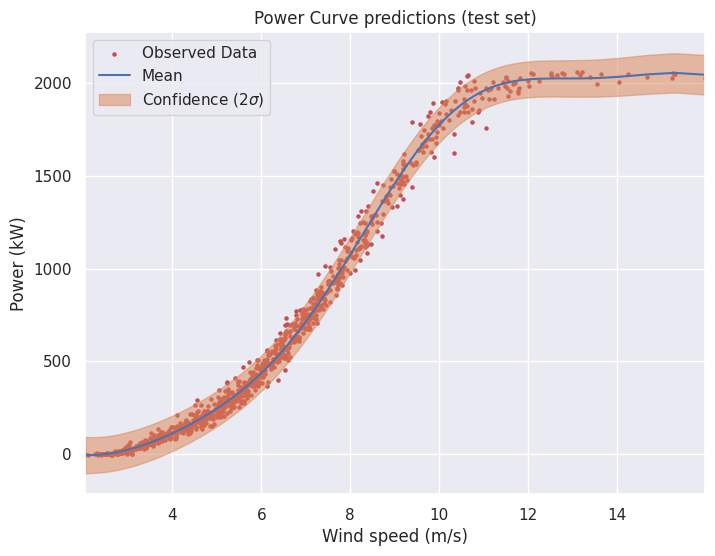

In [29]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xmargin(0)
    ax.set_title("Power Curve predictions (test set)")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power (kW)")
    
    # Get upper and lower confidence bounds
    lower, upper = test_pred.confidence_region()
    # Plot training data
    ax.scatter(test.wind_speed, test.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(test_sort.wind_speed, test_pred_tf, color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(test_sort.wind_speed, lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])
    
figs["pc_test"] = f

## Wind speed + direction w/ARD

In [23]:
X_test2 = torch.tensor(test_sort_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)

X_train2 = torch.tensor(train_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)
y_train2 = torch.tensor(train_std.power, dtype=torch.float32)

model2, likelihood2 = power_curve.fit(X_train2, y_train2, dims=2)
test_pred2 = power_curve.predict(model2, likelihood2, X_test2)

Iter 1/100 - Loss: 0.808   lengthscale: [[0.6931471824645996, 0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.768   lengthscale: [[0.7443966269493103, 0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.727   lengthscale: [[0.7978816032409668, 0.7979466319084167]]   noise: 0.598
Iter 4/100 - Loss: 0.686   lengthscale: [[0.8533725142478943, 0.8536346554756165]]   noise: 0.554
Iter 5/100 - Loss: 0.645   lengthscale: [[0.9106147289276123, 0.9112817645072937]]   noise: 0.513
Iter 6/100 - Loss: 0.604   lengthscale: [[0.9693244099617004, 0.9706970453262329]]   noise: 0.474
Iter 7/100 - Loss: 0.562   lengthscale: [[1.0291848182678223, 1.0316838026046753]]   noise: 0.437
Iter 8/100 - Loss: 0.520   lengthscale: [[1.089846134185791, 1.0940454006195068]]   noise: 0.403
Iter 9/100 - Loss: 0.478   lengthscale: [[1.1509325504302979, 1.1575888395309448]]   noise: 0.370
Iter 10/100 - Loss: 0.435   lengthscale: [[1.2120496034622192, 1.2221266031265259]]   noise: 0.340
Iter 11/100 - Loss: 

Iter 85/100 - Loss: -1.116   lengthscale: [[1.294098138809204, 4.97971248626709]]   noise: 0.006
Iter 86/100 - Loss: -1.116   lengthscale: [[1.2959364652633667, 5.011460781097412]]   noise: 0.006
Iter 87/100 - Loss: -1.115   lengthscale: [[1.2979960441589355, 5.043098449707031]]   noise: 0.006
Iter 88/100 - Loss: -1.115   lengthscale: [[1.3001340627670288, 5.074626922607422]]   noise: 0.006
Iter 89/100 - Loss: -1.115   lengthscale: [[1.3021721839904785, 5.106044769287109]]   noise: 0.006
Iter 90/100 - Loss: -1.115   lengthscale: [[1.3039703369140625, 5.137353420257568]]   noise: 0.006
Iter 91/100 - Loss: -1.115   lengthscale: [[1.3054007291793823, 5.16855001449585]]   noise: 0.006
Iter 92/100 - Loss: -1.115   lengthscale: [[1.3063898086547852, 5.199633598327637]]   noise: 0.006
Iter 93/100 - Loss: -1.115   lengthscale: [[1.3069239854812622, 5.2305989265441895]]   noise: 0.006
Iter 94/100 - Loss: -1.116   lengthscale: [[1.3070167303085327, 5.261441230773926]]   noise: 0.006
Iter 95/100 

In [24]:
test_pred_tf2 = test_pred2.mean.numpy() * train.power.std() + train.power.mean()
test_rmse2 = mean_squared_error(test_pred_tf2, test_sort.power, squared=False)
test_rmse2_rel = test_rmse2/test_sort.power.mean()*100

test_mae2 = mean_absolute_error(test_pred_tf2, test_sort.power)

print(f"Test RMSE: {test_rmse2} kW")
print(f"Test RMSE (%): {test_rmse2_rel}")
print(f"Test MAE: {test_mae2} kW")

Test RMSE: 45.46165033338206 kW
Test RMSE (%): 7.344564220429868
Test MAE: 31.807899026334475 kW


## Wind speed, direction, and TI w/ARD

In [25]:
if SAVE_FIGS:
    save_figs(figs)

In [26]:
X_test3 = torch.tensor(test_sort_std[["wind_speed", "wind_dir", "turbulence_intensity"]].values, dtype=torch.float32)

X_train3 = torch.tensor(train_std[["wind_speed", "wind_dir", "turbulence_intensity"]].values, dtype=torch.float32)
y_train3 = torch.tensor(train_std.power, dtype=torch.float32)

model3, likelihood3 = power_curve.fit(X_train3, y_train3, dims=3)
test_pred3 = power_curve.predict(model3, likelihood3, X_test3)

Iter 1/100 - Loss: 0.808   lengthscale: [[0.6931471824645996, 0.6931471824645996, 0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.768   lengthscale: [[0.7443966269493103, 0.7443966269493103, 0.7443819046020508]]   noise: 0.644
Iter 3/100 - Loss: 0.727   lengthscale: [[0.7978816032409668, 0.7979466319084167, 0.7977740168571472]]   noise: 0.598
Iter 4/100 - Loss: 0.686   lengthscale: [[0.8533722162246704, 0.8536346554756165, 0.8531125783920288]]   noise: 0.554
Iter 5/100 - Loss: 0.645   lengthscale: [[0.9106128811836243, 0.9112817049026489, 0.9102911353111267]]   noise: 0.513
Iter 6/100 - Loss: 0.604   lengthscale: [[0.9693193435668945, 0.9706968069076538, 0.9692339897155762]]   noise: 0.474
Iter 7/100 - Loss: 0.562   lengthscale: [[1.029174566268921, 1.0316832065582275, 1.029858112335205]]   noise: 0.437
Iter 8/100 - Loss: 0.520   lengthscale: [[1.0898295640945435, 1.09404456615448, 1.0920639038085938]]   noise: 0.403
Iter 9/100 - Loss: 0.478   lengthscale: [[1.1509090662002563

Iter 77/100 - Loss: -1.114   lengthscale: [[1.294607162475586, 4.720393657684326, 7.013084411621094]]   noise: 0.005
Iter 78/100 - Loss: -1.114   lengthscale: [[1.2934424877166748, 4.753322124481201, 7.083179950714111]]   noise: 0.005
Iter 79/100 - Loss: -1.115   lengthscale: [[1.2923882007598877, 4.786055564880371, 7.150808811187744]]   noise: 0.005
Iter 80/100 - Loss: -1.115   lengthscale: [[1.2915691137313843, 4.818613529205322, 7.216024875640869]]   noise: 0.005
Iter 81/100 - Loss: -1.116   lengthscale: [[1.2911112308502197, 4.851009845733643, 7.27890682220459]]   noise: 0.006
Iter 82/100 - Loss: -1.116   lengthscale: [[1.2911403179168701, 4.883259296417236, 7.3395490646362305]]   noise: 0.006
Iter 83/100 - Loss: -1.116   lengthscale: [[1.291702389717102, 4.915372371673584, 7.398056507110596]]   noise: 0.006
Iter 84/100 - Loss: -1.116   lengthscale: [[1.2928153276443481, 4.947360038757324, 7.454541206359863]]   noise: 0.006
Iter 85/100 - Loss: -1.116   lengthscale: [[1.294401288032

In [27]:
test_pred_tf3 = test_pred3.mean.numpy() * train.power.std() + train.power.mean()
test_rmse3 = mean_squared_error(test_pred_tf3, test_sort.power, squared=False)
test_rmse3_rel = test_rmse3/test_sort.power.mean()*100

test_mae3 = mean_absolute_error(test_pred_tf3, test_sort.power)

print(f"Test RMSE: {test_rmse3} kW")
print(f"Test RMSE (%): {test_rmse3_rel}")
print(f"Test MAE: {test_mae3} kW")

Test RMSE: 45.46220555792205 kW
Test RMSE (%): 7.344653919819591
Test MAE: 31.808636544645022 kW
